A cell over two columns:

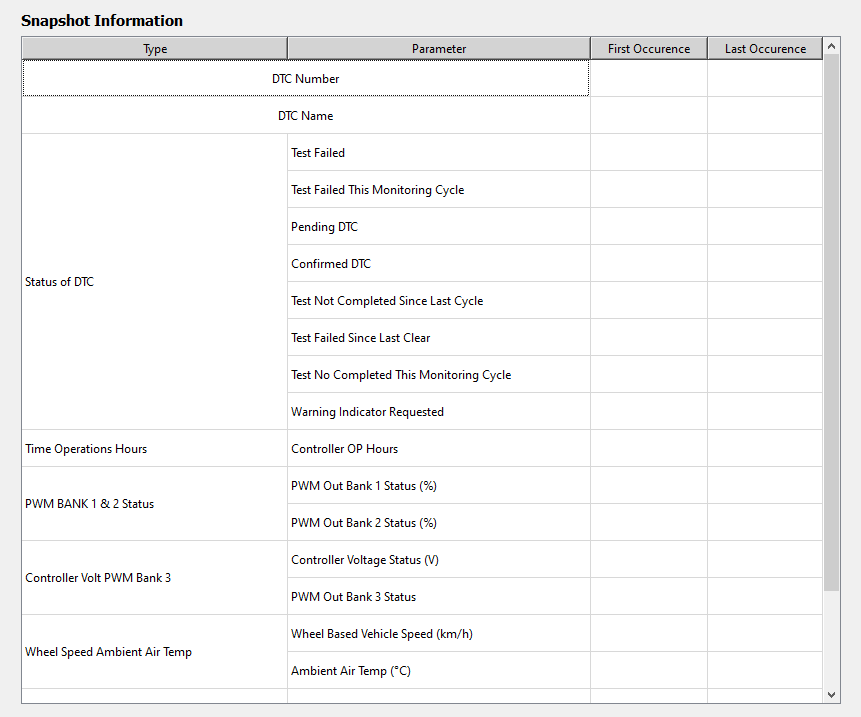

In [ ]:
class SnapshotInformationLayout(QVBoxLayout):
    """Vertical layout for snapshot information"""

    def __init__(self):
        super().__init__()
        titleLabel = QLabel("Snapshot Information")
        titleLabel.setStyleSheet("font-weight: bold; font-size: 15px;")
        self.snapshotTable = DTCTableWidget(
            DTCMonitorConstants.SNAPSHOT_HEADER, [])
        self.snapshotTable.setRowCount(DTCMonitorConstants.SNAPSHOT_ROW)
        self.snapshotTable.setColumnCount(DTCMonitorConstants.SNAPSHOT_COLUMN)
        self.snapshotTable.setSortingEnabled(False)

        # add widgets
        self.addWidget(titleLabel)
        self.addWidget(self.snapshotTable)

        self.addParameterColumns()
        self.snapshotTable.resizeColumnsToContents()

        DTCSignals.UpdateSnapshotTable.connect(self.updateTable)

    def addParameterColumns(self):
        """Add fixed parameters to the columns."""
        rowIndex = 0
        col1 = 0
        col2 = 1
        for key, val in DTCMonitorConstants.SNAPSHOT_COLUMN_ITEM.items():
            newItem = QTableWidgetItem(key)
            valLen = len(val)
            if valLen > 1:
                self.snapshotTable.setSpan(rowIndex, col1, valLen, 1)
            elif valLen == 1 and not val[0]:
                self.snapshotTable.setSpan(rowIndex, col1, 1, 2)
                newItem.setTextAlignment(Qt.AlignCenter)
            self.snapshotTable.setItem(rowIndex, col1, newItem)
            if valLen > 0:
                for i in val:
                    newItem = QTableWidgetItem(i)
                    self.snapshotTable.setItem(rowIndex, col2, newItem)
                    rowIndex += 1
            else:
                rowIndex += 1

    def updateTable(self, data: list):
        """Update data."""
        for index in range(DTCMonitorConstants.SNAPSHOT_ROW):
            dt1 = data[0][index]
            dt2 = data[1][index]
            item1 = QTableWidgetItem(dt1)
            self.snapshotTable.setItem(index, 2, item1)
            item2 = QTableWidgetItem(dt2)
            self.snapshotTable.setItem(index, 3, item2)